In [1]:
import os
import numpy as np
import cv2
import json 

# ------------------------------
# ENTER YOUR REQUIREMENTS HERE:
# ...
PATH_TO_YOUR_IMAGES = 'testdata/extrinsic_calib_set_1/'
MARKER_LENGTH = 0.25
# ------------------------------

json_file_path = './calibration.json'

with open(json_file_path, 'r') as file: # Read the JSON file
    json_data = json.load(file)

mtx = np.array(json_data['mtx'])
dst = np.array(json_data['dist'])

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_36h11) # TODO: difference between 36h11 and 36H11
params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(dictionary, params)

In [2]:
image_paths = [os.path.join(PATH_TO_YOUR_IMAGES, f) for f in os.listdir(PATH_TO_YOUR_IMAGES) if f.endswith(".JPG")]

img_path = image_paths[5] # select image
image_color = cv2.imread(img_path)
image = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

h,  w = image.shape[:2]
#newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dst, (w,h), 1, (w,h))
#image = cv2.undistort(image, mtx, dst, None, newcameramtx)


marker_corners, marker_ids, rejectedCandidates = detector.detectMarkers(image)
marker_corners

rvecs, tvecs, objpts = cv2.aruco.estimatePoseSingleMarkers(marker_corners, markerLength=MARKER_LENGTH, cameraMatrix=mtx, distCoeffs=dst)
marker_ids = [v.item() for v in marker_ids]
# objpts consistent across markers

In [3]:
rvecs, tvecs, marker_ids

(array([[[ 1.89914224, -1.7293225 ,  0.32871431]],
 
        [[ 0.4586851 ,  2.80251794, -0.52765062]],
 
        [[ 0.22926396,  3.20810836,  0.09182678]]]),
 array([[[-0.9081883 , -0.26148593,  1.38576549]],
 
        [[ 1.47876824,  0.15076661,  1.78698031]],
 
        [[ 0.50006231,  0.9771672 ,  2.2708553 ]]]),
 [15, 12, 14])

In [4]:
rvecs[0,0,:]

array([ 1.89914224, -1.7293225 ,  0.32871431])

In [5]:
objpts.reshape((-1,3))

array([[-0.125,  0.125,  0.   ],
       [ 0.125,  0.125,  0.   ],
       [ 0.125, -0.125,  0.   ],
       [-0.125, -0.125,  0.   ]], dtype=float32)

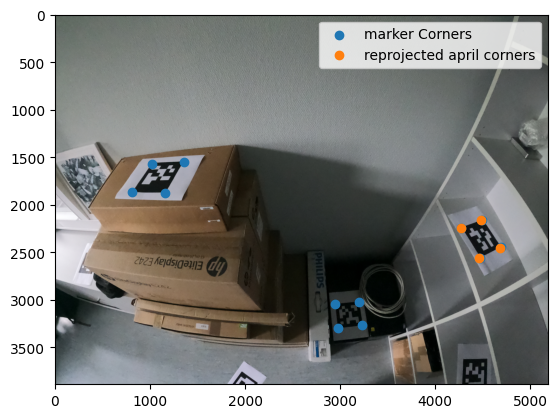

In [6]:
REPR_MARKER=1
rvec = rvecs[REPR_MARKER,0,:]
tvec = tvecs[REPR_MARKER,0,:]
rotation_matrix, _ = cv2.Rodrigues(rvec)

# Camera pose: the inverse of the extrinsic matrix (rotation + translation)
camera_extrinsics = np.eye(4)
camera_extrinsics[:3, :3] = rotation_matrix
tvec = tvec.flatten()
#tvec = - rotation_matrix.T @ (tvec)
camera_extrinsics[:3, 3] = tvec
camera_mat = np.eye(4)
camera_mat[:3,:3] = mtx
P = camera_mat @ camera_extrinsics
P = P[:3,:] # we only had 4 rows for multiplication before
world_corners = objpts.reshape((-1,3))
image_pts = P @ np.hstack((world_corners,np.ones((world_corners.shape[0],1)))).T
# recover homogeneous coordinates
image_pts = image_pts / image_pts[-1,:]
image_pts = image_pts[:2,:]
image_pts.T
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(np.hstack(marker_corners)[0,:,0],np.hstack(marker_corners)[0,:,1],label="marker Corners")
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected april corners")
plt.legend()

move points to coordinate system with camera in center

In [7]:
REPR_MARKER=1
rvec = rvecs[REPR_MARKER,0,:].flatten()
tvec = tvecs[REPR_MARKER,0,:]
rotation_matrix, _ = cv2.Rodrigues(rvec)

# rvec and tvec describe the transform from marker coordinates to camera coordinates with the inverse rigid transformation being the camera pose
# thus rvec and tvec already are the pose of the marker and the inverse (=camera pose)describes the transformation from camera to marker coords


# Camera pose: the inverse of the extrinsic matrix (rotation + translation)
rigid_motion = np.eye(4)
rigid_motion[:3, :3] = rotation_matrix
rigid_motion[:3,3] = tvec
marker_world_corners = objpts.reshape((-1,3))
marker_world_corners_cam = rigid_motion @ np.hstack((marker_world_corners,np.ones((marker_world_corners.shape[0],1)))).T
marker_world_corners_cam = marker_world_corners_cam[:3,:].T
marker_world_corners_cam



array([[1.63720495, 0.22916661, 1.78586378],
       [1.40758294, 0.29353881, 1.71083077],
       [1.32033152, 0.07236661, 1.78809684],
       [1.54995353, 0.0079944 , 1.86312985]])

In [8]:
def convert_to_cam_system(rvec, tvec, marker_world_corners):
    rvec = rvec.flatten()
    rotation_matrix, _ = cv2.Rodrigues(rvec)
    rigid_motion = np.eye(4)
    rigid_motion[:3, :3] = rotation_matrix
    rigid_motion[:3,3] = tvec
    marker_world_corners_cam = rigid_motion @ np.hstack((marker_world_corners,np.ones((marker_world_corners.shape[0],1)))).T
    marker_world_corners_cam = marker_world_corners_cam[:3,:].T
    return marker_world_corners_cam, rigid_motion
    

In [9]:
from collections import defaultdict

img_markers = dict()
for rvec, tvec, mid in zip(rvecs, tvecs, marker_ids):
    wpts, trans = convert_to_cam_system(rvec, tvec, marker_world_corners=objpts.reshape((-1,3)))
    # note that these trans tranforms are pose matrices
    img_markers[mid] = (wpts, trans)

In [10]:
def estimate_april_pose(img_path):
    image_color = cv2.imread(img_path)
    image = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    h,  w = image.shape[:2]
    #newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dst, (w,h), 1, (w,h))
    #image = cv2.undistort(image, mtx, dst, None, newcameramtx)


    marker_corners, marker_ids, rejectedCandidates = detector.detectMarkers(image)
    marker_corners

    rvecs, tvecs, objpts = cv2.aruco.estimatePoseSingleMarkers(marker_corners, markerLength=MARKER_LENGTH, cameraMatrix=mtx, distCoeffs=dst)
    marker_ids = [v.item() for v in marker_ids]
    return rvecs, tvecs, marker_ids, objpts

In [ ]:
import plotly.graph_objects as go
from stl import mesh
def plot_3d_points_and_camera_centers(points, extrinsic_matrices):
    """
    Plots a 3D scatter plot of the given points and camera representations from extrinsic matrices.

    Parameters:
    - points: A 3xN NumPy array, where each column represents a point (x, y, z).
    - extrinsic_matrices: A list of 4x4 NumPy arrays representing the extrinsic matrices for each camera.
    """
    # Ensure points is a NumPy array
    points = np.asarray(points)

    # Check if the input is a 3xN array
    if points.shape[0] != 3:
        raise ValueError("Input points must be a 3xN NumPy array.")

    # Extract x, y, z coordinates
    x = points[0, :]
    y = points[1, :]
    z = points[2, :]

    # Create a 3D scatter plot for the points
    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=5,
            color='blue',  # Marker color for points
            opacity=0.8
        ),
        name='3D Points'
    )])

    def create_camera_cone(extrinsic, name, color=None):
        # Transform the cone points using the extrinsic matrix
        rotation_matrix = extrinsic[:3, :3].T
        camera_center = -rotation_matrix @ extrinsic[:3, 3]

        # def rotate_and_translate(vertices, rotation_matrix, translation_vector):
        #     # Apply rotation
        #     rotated_vertices = vertices @ rotation_matrix.T  # Ensure correct shape
        #     # Apply translation
        #     translated_vertices = rotated_vertices + translation_vector
        #     return translated_vertices

        # # Load the STL file
        # your_mesh = mesh.Mesh.from_file('pyramid.stl')

        # # Extract vertices
        # vertices = your_mesh.vectors.reshape(-1, 3)

        # # Rotate and translate the frustum
        # transformed_vertices = rotate_and_translate(vertices, rotation_matrix, camera_center)

        # # Compute forward vector 
        # frustum = go.Mesh3d(
        #     x=transformed_vertices[:, 0],
        #     y=transformed_vertices[:, 1],
        #     z=transformed_vertices[:, 2],
        #     opacity=0.75,
        #     color='blue'
        # )

        # Create axes representing the camera's orientation
        axes_length = 0.25
        x_axis = go.Scatter3d(
            x=[camera_center[0], camera_center[0] + axes_length * rotation_matrix[0, 0]],
            y=[camera_center[1], camera_center[1] + axes_length * rotation_matrix[1, 0]],
            z=[camera_center[2], camera_center[2] + axes_length * rotation_matrix[2, 0]],
            mode='lines',
            line=dict(color='red', width=5),
            name=name
        )

        y_axis = go.Scatter3d(
            x=[camera_center[0], camera_center[0] + axes_length * rotation_matrix[0, 1]],
            y=[camera_center[1], camera_center[1] + axes_length * rotation_matrix[1, 1]],
            z=[camera_center[2], camera_center[2] + axes_length * rotation_matrix[2, 1]],
            mode='lines',
            line=dict(color='green', width=5),
            name=name
        )

        z_axis = go.Scatter3d(
            x=[camera_center[0], camera_center[0] + axes_length * rotation_matrix[0, 2]],
            y=[camera_center[1], camera_center[1] + axes_length * rotation_matrix[1, 2]],
            z=[camera_center[2], camera_center[2] + axes_length * rotation_matrix[2, 2]],
            mode='lines',
            line=dict(color='blue', width=5),
            name=name
        )

        dot = None
        if color is not None:
            dot = go.Scatter3d(
                x=[camera_center[0]],
                y=[camera_center[1]],
                z=[camera_center[2]],
                mode='markers',
                marker=dict(
                    size=5,
                    color=color,  # Marker color for points
                    opacity=1.0
                ),
                name=name
            )

        res = [x_axis, y_axis, z_axis]
        if dot is not None:
            res.append(dot)
        return res

    # Plot camera representations from extrinsic matrices
    for idx, tp in enumerate(extrinsic_matrices):
        if isinstance(tp, tuple):
            if len(tp) == 2:
                name= tp[0]
                color=None
                extrinsic = tp[1]
            elif len(tp) == 3:
                name=tp[0]
                color=tp[1]
                extrinsic=tp[2]
        else:
            extrinsic = tp
            color=None
            name = f"cam_{idx}"
        # Create the camera cone
        cone_point_objects = create_camera_cone(extrinsic, name,color=color)

        # Add the cone to the plot
        [fig.add_trace(cone_points) for cone_points in cone_point_objects]

    # Set the layout
    fig.update_layout(
        title='3D Scatter Plot of Points and Camera Representations',
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis'
        )
    )

    # Show the figure in the Jupyter Notebook
    fig.show()

origin_cam_ext = np.eye(4)

# Define a list of extrinsic matrices (4x4)
extrinsic_matrices = [
    origin_cam_ext
]
for (m, trans) in img_markers.values():
    wpts = np.vstack((wpts, m))
    _r = trans[:3,:3]
    _r = _r.T
    _t =  (-_r)@trans[:3,3]
    _E = np.eye(4)
    _E[:3,:3] = _r
    _E[:3,3] = _t
    extrinsic_matrices.append(_E)

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

In [12]:
rvecs, tvecs, marker_ids, objpts = estimate_april_pose(image_paths[6])
img_markers_2 = dict()
for rvec, tvec, mid in zip(rvecs, tvecs, marker_ids):
    wpts, trans = convert_to_cam_system(rvec, tvec, marker_world_corners=objpts.reshape((-1,3)))
    # note that these trans tranforms are pose matrices
    img_markers_2[mid] = (wpts, trans)

In [13]:
img_markers.keys(), img_markers_2.keys()

(dict_keys([15, 12, 14]), dict_keys([15, 10, 11]))

convert img_markers_2 to img_markers frame of reference

In [14]:
# goal is pose of marker 11
img_markers[15][1]

array([[ 0.14444374, -0.97338876, -0.17790538, -0.9081883 ],
       [-0.84022675, -0.02569094, -0.54162623, -0.26148593],
       [ 0.52264233,  0.22771537, -0.82157818,  1.38576549],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [15]:
# move cam 2 to img_marker (out edge, trans is pose)
trans = img_markers_2[15][1]
_r = trans[:3,:3]
_r = _r.T
_t =  -_r@trans[:3,3]
_E = np.eye(4)
_E[:3,:3] = _r
_E[:3,3] = _t
new_cam_pos = img_markers[15][1] @ _E  # second factor here is the pose of connecting marker 11 as seen from frame of reference 2
new_cam_pos = new_cam_pos[:3, :]

# this was calculated as (cam_1)-[pose]->(15)<-[trans]-(cam_2)


In [16]:
new_cam_pos

array([[ 0.16097715,  0.98511074, -0.06035889, -0.73953705],
       [-0.96872423,  0.16940863,  0.18131213,  0.28464947],
       [ 0.18883784,  0.02928401,  0.98157155, -0.02683687]])

now try the rebind neighbors with a third frame of reference

In [17]:
# rvecs, tvecs, marker_ids, objpts = estimate_april_pose(image_paths[1])
# img_markers_3 = dict()
# for rvec, tvec, mid in zip(rvecs, tvecs, marker_ids):
#     wpts, trans = convert_to_cam_system(rvec, tvec, marker_world_corners=objpts.reshape((-1,3)))
#     # note that these trans tranforms are pose matrices
#     img_markers_3[mid] = (wpts, trans)

# img_markers_3.keys()

In [18]:
# actually stored is always pose, label is according to aggregation direction
# (cam1)-pose->(m15)<-trans-(cam2)-pose->(m11)
# => (cam1)-pose->(m15)<-trans-(cam2)<-trans-(m11)
# => (cam1)-pose->(m15)<-trans15-2 @ trans2_11-(m11)

pose = img_markers[15][1]

trans152 = img_markers_2[15][1]
_r = trans152[:3,:3]
_r = _r.T
_t =  -_r@trans152[:3,3]
_E152 = np.eye(4)
_E152[:3,:3] = _r
_E152[:3,3] = _t

trans211 = img_markers_2[11][1]
_r = trans211[:3,:3]
_r = _r.T
_t =  -_r@trans211[:3,3]
_E211 = np.eye(4)
_E211[:3,:3] = _r
_E211[:3,3] = _t
new_m11_pos = pose @ _E152 @ _E211
new_m11_pos = new_m11_pos[:3, :]

def invv(trans):
    _r = trans[:3,:3]
    _r = _r.T
    _t =  -_r@trans[:3,3]
    _E211 = np.eye(4)
    _E211[:3,:3] = _r
    _E211[:3,3] = _t
    return _E211
#new_m11_pos = invv(new_m11_pos)

In [19]:
np.hstack((img_markers_2[11][0],np.ones((4,1))))

array([[-1.03379336,  0.58092152,  3.19178048,  1.        ],
       [-0.90625102,  0.36598395,  3.18588215,  1.        ],
       [-0.69186953,  0.4925731 ,  3.20859258,  1.        ],
       [-0.81941187,  0.70751067,  3.21449091,  1.        ]])

In [20]:
m11_pts = new_cam_pos @ np.hstack((img_markers_2[11][0],np.ones((img_markers_2[11][0].shape[0],1)))).T
# recover homogeneous coordinates
m11_pts = m11_pts[:3,:]
m11_pts.T

array([[-0.52633446,  1.96323177,  2.92791646],
       [-0.71718435,  1.8021967 ,  2.93991742],
       [-0.55934028,  1.62008312,  3.0063997 ],
       [-0.36849038,  1.7811182 ,  2.99439875]])

In [21]:
new_cam_pos

array([[ 0.16097715,  0.98511074, -0.06035889, -0.73953705],
       [-0.96872423,  0.16940863,  0.18131213,  0.28464947],
       [ 0.18883784,  0.02928401,  0.98157155, -0.02683687]])

In [22]:
img_markers_2[11][0]

array([[-1.03379336,  0.58092152,  3.19178048],
       [-0.90625102,  0.36598395,  3.18588215],
       [-0.69186953,  0.4925731 ,  3.20859258],
       [-0.81941187,  0.70751067,  3.21449091]])

In [23]:
p = img_markers_2[11][0][0,:]
extrinsic = invv(new_cam_pos)
rotation_matrix = extrinsic[:3, :3]
camera_center = -rotation_matrix @ extrinsic[:3, 3]
pc =  ((-rotation_matrix).T @ extrinsic[:3, 3]) # this actually is the camera center

#p =  ((-rotation_matrix).T @ (p-camera_center)) # this actually is the camera center

_p = np.eye(4)
_p[:3,3] = p
_C = np.eye(4)
_C[:3,:4] = new_cam_pos
p = _C @ _p
p = p[:3,3]
p

array([-0.52633446,  1.96323177,  2.92791646])

for reference, manually compute pose of marker using estimated pose matrix

In [24]:
E = new_m11_pos
p2 = -E[:3,:3].T @ E[:3,3]
p2

array([-1.24751017, -0.15656355,  3.19847822])

In [ ]:

origin_cam_ext = np.eye(4)

# Define a list of extrinsic matrices (4x4)
extrinsic_matrices = [
    origin_cam_ext,
    invv(new_cam_pos),
    new_m11_pos
]
wpts = np.zeros((0,3))
for (m, trans) in img_markers.values():
    wpts = np.vstack((wpts, m))
    _r = trans[:3,:3]
    _r = _r.T
    _t =  -_r@trans[:3,3]
    _E = np.eye(4)
    _E[:3,:3] = _r
    _E[:3,3] = _t
    extrinsic_matrices.append(_E)

wpts = np.vstack((wpts, pc))
wpts = np.vstack((wpts, p))

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

this is actually correct

In [26]:
import networkx as nx
import random
import numpy as np
import pathlib
seed = 42
random.seed(seed)
np.random.seed(seed)

pose_graph = nx.DiGraph()

for img_path in image_paths:
    rvecs, tvecs, marker_ids, objpts = estimate_april_pose(img_path)
    img_markers = dict()
    node_name = pathlib.Path(img_path).name
    pose_graph.add_node(node_name)
    for rvec, tvec, mid in zip(rvecs, tvecs, marker_ids):
        wpts, trans = convert_to_cam_system(rvec, tvec, marker_world_corners=objpts.reshape((-1,3)))
        # note that these trans tranforms are pose matrices
        img_markers[mid] = (wpts, trans)
        if not pose_graph.has_node(mid):
            pose_graph.add_node(mid)
        
        # _r = trans[:3,:3]
        # _r = _r.T
        # _t =  -_r@trans[:3,3]
        # _E = np.eye(4)
        # _E[:3,:3] = _r
        # _E[:3,3] = _t
        pose_graph.add_edge(node_name, mid, trans=trans, points3d=wpts.T)
    #inliers = correspondences[:, mask.astype(bool)[:,0]]
        
    
    #inliers = correspondences[:, np.where(mask)]
    #triangulatedPoints = triangulatedPoints.T
    #print(correspondences,np.where(mask), mask, triangulatedPoints.shape)

In [27]:
components = sorted(nx.connected_components(nx.Graph(pose_graph)), key=len, reverse=True)
pose_graph = pose_graph.subgraph(components[0])
print(f"graph consists of {len(components)} connected component(s), choosing largest")

graph consists of 1 connected component(s), choosing largest


In [28]:
# choosing specific subgraph for now
subgraph_nodes = ["GOPR0012.JPG","GOPR0013.JPG","GOPR0008.JPG",11,15]
pose_graph = pose_graph.subgraph(subgraph_nodes).copy()

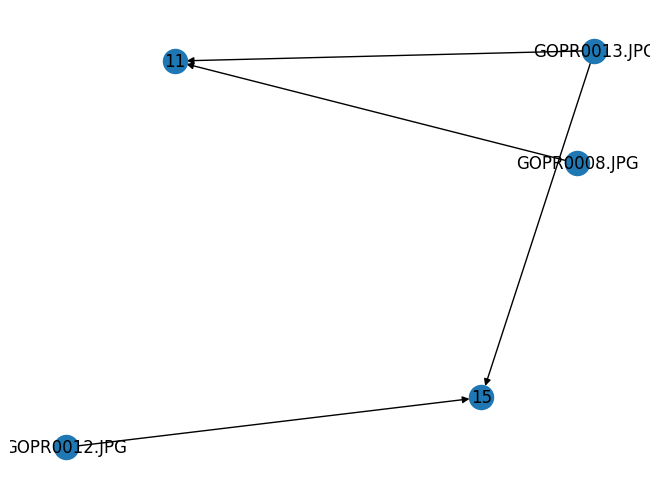

In [29]:
import matplotlib.pyplot as plt
graph_poses = nx.kamada_kawai_layout(pose_graph)

plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses)
plt.show(
)

In [30]:
seed = 42
random.seed(seed)
np.random.seed(seed)
trans_key="trans"
model_key = "model"
def inverse_transformation(T):
    return np.linalg.inv(T)

def update_data(pose_graph, pivot_node, neighbor, new_trans):
    node_data = pose_graph.nodes[pivot_node]
    new_data = {pivot_node: {**node_data}}
    new_data[pivot_node][model_key][neighbor] = new_trans
    nx.set_node_attributes(pose_graph, new_data)

In [31]:
nodes = list(pose_graph.nodes)
for n in nodes:
    n_data = pose_graph[n]
    nx.set_node_attributes(pose_graph, {n:{model_key: {n: np.eye(4)},**n_data}})

In [32]:
pivot_node = "GOPR0012.JPG"
out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key]) for n in pose_graph.out_edges(pivot_node)] 
in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key]) for n in pose_graph.in_edges(pivot_node)] 
in_neighbors = [(n, inverse_transformation(t)) for (n,t) in in_neighbors] # this lets us handle every edge if it was outgoing
neighbors = out_neighbors + in_neighbors # every transformation now is a pose matrix (as opposed to extrinsic)
for neighbor, pose in neighbors:
    print(pose_graph.nodes[pivot_node][model_key])
    print(f"pose {pose}")
    print(pose_graph.nodes[neighbor][model_key])

    # add to pivot model applying pose
    new_pose = pose @ pose_graph.nodes[neighbor][model_key][neighbor]
    update_data(pose_graph, pivot_node, neighbor, new_pose)

    # get neighbors neighbors
    out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key],n) for n in pose_graph.out_edges(neighbor)] 
    in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key],n) for n in pose_graph.in_edges(neighbor)]
    in_neighbors = [(n, inverse_transformation(t),e) for (n,t,e) in in_neighbors]
    neighbors_neighbors = out_neighbors + in_neighbors
    # reconnect to pivot node applying pose to edge
    for nn, npose, edge in neighbors_neighbors:
        if nn == pivot_node:
            continue
        pose_graph.remove_edge(*edge)
        new_pose = pose @ npose
        pose_graph.add_edge(pivot_node, nn, **{trans_key: new_pose})
    pose_graph.remove_node(neighbor)

        
    

{'GOPR0012.JPG': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}
pose [[ 0.14444374 -0.97338876 -0.17790538 -0.9081883 ]
 [-0.84022675 -0.02569094 -0.54162623 -0.26148593]
 [ 0.52264233  0.22771537 -0.82157818  1.38576549]
 [ 0.          0.          0.          1.        ]]
{15: array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


In [33]:
extrinsic_matrices = []
for node, trans in pose_graph.nodes[pivot_node][model_key].items():
    extrinsic_matrices.append((str(node),inverse_transformation(trans)))

# Define a list of extrinsic matrices (4x4)

wpts = np.zeros((0,3))

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

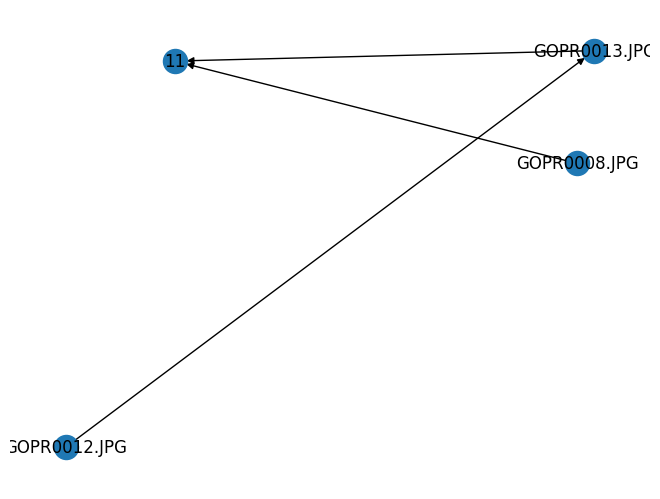

In [34]:
plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses)
plt.show(
)



In [35]:
pivot_node = "GOPR0012.JPG"
out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key]) for n in pose_graph.out_edges(pivot_node)] 
in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key]) for n in pose_graph.in_edges(pivot_node)] 
in_neighbors = [(n, inverse_transformation(t)) for (n,t) in in_neighbors] # this lets us handle every edge if it was outgoing
neighbors = out_neighbors + in_neighbors # every transformation now is a pose matrix (as opposed to extrinsic)
for neighbor, pose in neighbors:
    print(pose_graph.nodes[pivot_node][model_key])
    print(f"pose {pose}")
    print(pose_graph.nodes[neighbor][model_key])

    # add to pivot model applying pose
    new_pose = pose @ pose_graph.nodes[neighbor][model_key][neighbor]
    update_data(pose_graph, pivot_node, neighbor, new_pose)

    # get neighbors neighbors
    out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key],n) for n in pose_graph.out_edges(neighbor)] 
    in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key],n) for n in pose_graph.in_edges(neighbor)]
    in_neighbors = [(n, inverse_transformation(t),e) for (n,t,e) in in_neighbors]
    neighbors_neighbors = out_neighbors + in_neighbors
    # reconnect to pivot node applying pose to edge
    for nn, npose, edge in neighbors_neighbors:
        if nn == pivot_node:
            continue
        pose_graph.remove_edge(*edge)
        new_pose = pose @ npose
        pose_graph.add_edge(pivot_node, nn, **{trans_key: new_pose})
    pose_graph.remove_node(neighbor)


{'GOPR0012.JPG': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), 15: array([[ 0.14444374, -0.97338876, -0.17790538, -0.9081883 ],
       [-0.84022675, -0.02569094, -0.54162623, -0.26148593],
       [ 0.52264233,  0.22771537, -0.82157818,  1.38576549],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])}
pose [[ 0.16097715  0.98511074 -0.06035889 -0.73953705]
 [-0.96872423  0.16940863  0.18131213  0.28464947]
 [ 0.18883784  0.02928401  0.98157155 -0.02683687]
 [ 0.          0.          0.          1.        ]]
{'GOPR0013.JPG': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


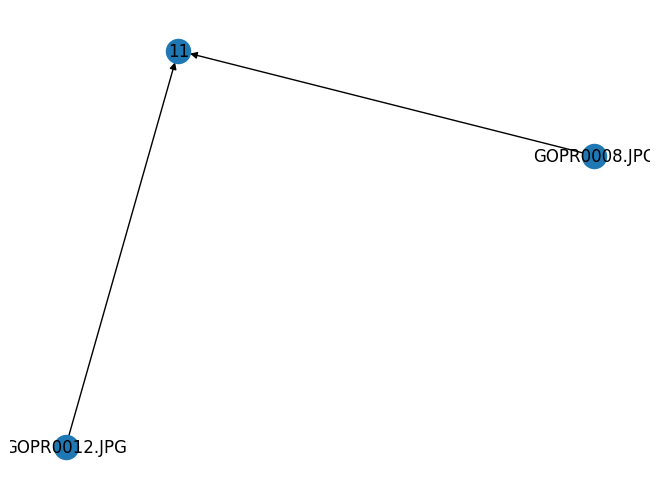

In [36]:
extrinsic_matrices = []
for node, trans in pose_graph.nodes[pivot_node][model_key].items():
    extrinsic_matrices.append((str(node),inverse_transformation(trans)))

# Define a list of extrinsic matrices (4x4)

wpts = np.zeros((0,3))

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses)
plt.show(
)


In [37]:
pivot_node = "GOPR0012.JPG"
out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key]) for n in pose_graph.out_edges(pivot_node)] 
in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key]) for n in pose_graph.in_edges(pivot_node)] 
in_neighbors = [(n, inverse_transformation(t)) for (n,t) in in_neighbors] # this lets us handle every edge if it was outgoing
neighbors = out_neighbors + in_neighbors # every transformation now is a pose matrix (as opposed to extrinsic)
for neighbor, pose in neighbors:
    print(pose_graph.nodes[pivot_node][model_key])
    print(f"pose {pose}")
    print(pose_graph.nodes[neighbor][model_key])

    # add to pivot model applying pose
    new_pose = pose @ pose_graph.nodes[neighbor][model_key][neighbor]
    update_data(pose_graph, pivot_node, neighbor, new_pose)

    # get neighbors neighbors
    out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key],n) for n in pose_graph.out_edges(neighbor)] 
    in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key],n) for n in pose_graph.in_edges(neighbor)]
    in_neighbors = [(n, inverse_transformation(t),e) for (n,t,e) in in_neighbors]
    neighbors_neighbors = out_neighbors + in_neighbors
    # reconnect to pivot node applying pose to edge
    for nn, npose, edge in neighbors_neighbors:
        if nn == pivot_node:
            continue
        pose_graph.remove_edge(*edge)
        new_pose = pose @ npose
        pose_graph.add_edge(pivot_node, nn, **{trans_key: new_pose})
    pose_graph.remove_node(neighbor)

{'GOPR0012.JPG': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), 15: array([[ 0.14444374, -0.97338876, -0.17790538, -0.9081883 ],
       [-0.84022675, -0.02569094, -0.54162623, -0.26148593],
       [ 0.52264233,  0.22771537, -0.82157818,  1.38576549],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'GOPR0013.JPG': array([[ 0.16097715,  0.98511074, -0.06035889, -0.73953705],
       [-0.96872423,  0.16940863,  0.18131213,  0.28464947],
       [ 0.18883784,  0.02928401,  0.98157155, -0.02683687],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])}
pose [[-0.76339957 -0.63137629  0.1363271  -0.54283737]
 [-0.6441403   0.7284543  -0.23331867  1.79165745]
 [ 0.04800382 -0.26592915 -0.96279661  2.96715808]
 [ 0.          0.          0.          1.        ]]
{11: array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


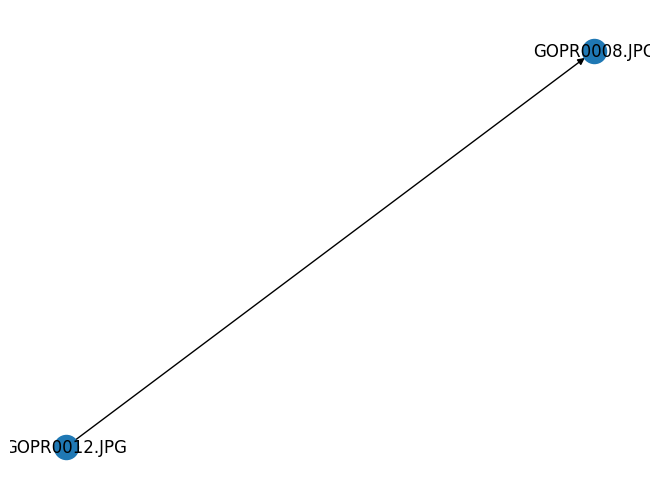

In [38]:
extrinsic_matrices = []
for node, trans in pose_graph.nodes[pivot_node][model_key].items():
    extrinsic_matrices.append((str(node),inverse_transformation(trans)))

# Define a list of extrinsic matrices (4x4)

wpts = np.zeros((0,3))

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses)
plt.show(
)

In [39]:
pivot_node = "GOPR0012.JPG"
out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key]) for n in pose_graph.out_edges(pivot_node)] 
in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key]) for n in pose_graph.in_edges(pivot_node)] 
in_neighbors = [(n, inverse_transformation(t)) for (n,t) in in_neighbors] # this lets us handle every edge if it was outgoing
neighbors = out_neighbors + in_neighbors # every transformation now is a pose matrix (as opposed to extrinsic)
for neighbor, pose in neighbors:
    print(pose_graph.nodes[pivot_node][model_key])
    print(f"pose {pose}")
    print(pose_graph.nodes[neighbor][model_key])

    # add to pivot model applying pose
    new_pose = pose @ pose_graph.nodes[neighbor][model_key][neighbor]
    update_data(pose_graph, pivot_node, neighbor, new_pose)

    # get neighbors neighbors
    out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key],n) for n in pose_graph.out_edges(neighbor)] 
    in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key],n) for n in pose_graph.in_edges(neighbor)]
    in_neighbors = [(n, inverse_transformation(t),e) for (n,t,e) in in_neighbors]
    neighbors_neighbors = out_neighbors + in_neighbors
    # reconnect to pivot node applying pose to edge
    for nn, npose, edge in neighbors_neighbors:
        if nn == pivot_node:
            continue
        pose_graph.remove_edge(*edge)
        new_pose = pose @ npose
        pose_graph.add_edge(pivot_node, nn, **{trans_key: new_pose})
    pose_graph.remove_node(neighbor)

{'GOPR0012.JPG': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), 15: array([[ 0.14444374, -0.97338876, -0.17790538, -0.9081883 ],
       [-0.84022675, -0.02569094, -0.54162623, -0.26148593],
       [ 0.52264233,  0.22771537, -0.82157818,  1.38576549],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'GOPR0013.JPG': array([[ 0.16097715,  0.98511074, -0.06035889, -0.73953705],
       [-0.96872423,  0.16940863,  0.18131213,  0.28464947],
       [ 0.18883784,  0.02928401,  0.98157155, -0.02683687],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 11: array([[-0.76339957, -0.63137629,  0.1363271 , -0.54283737],
       [-0.6441403 ,  0.7284543 , -0.23331867,  1.79165745],
       [ 0.04800382, -0.26592915, -0.96279661,  2.96715808],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])}
pose [[ 0.92753716 -0.36690193  0.07111811 -0.96000247]
 [ 0.21221822  0.36042849 -0.90832523  3.46380699]
 [ 0.3076332

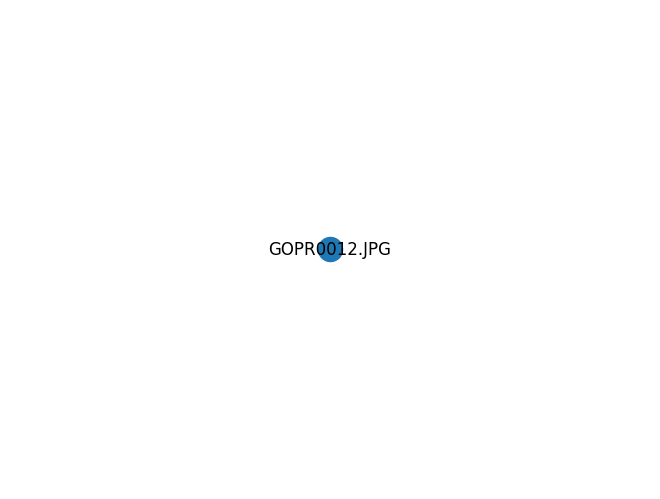

In [40]:
extrinsic_matrices = []
for node, trans in pose_graph.nodes[pivot_node][model_key].items():
    if str(node).endswith("JPG"):
        color = "blue"
    else:
        color = "orange"
    extrinsic_matrices.append((str(node),color, inverse_transformation(trans)))

# Define a list of extrinsic matrices (4x4)

wpts = np.zeros((0,3))

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses)
plt.show(
)

## actually implement recursive graph resolution as formula

In [41]:
seed = 42
random.seed(seed)
np.random.seed(seed)
trans_key="trans"
model_key = "model"
def inverse_transformation(T):
    return np.linalg.inv(T)

def update_data(pose_graph, pivot_node, neighbor, new_trans):
    node_data = pose_graph.nodes[pivot_node]
    new_data = {pivot_node: {**node_data}}
    new_data[pivot_node][model_key][neighbor] = new_trans
    nx.set_node_attributes(pose_graph, new_data)

def preprocess(pose_graph, model_key=model_key):
    nodes = list(pose_graph.nodes)
    for n in nodes:
        n_data = pose_graph[n]
        nx.set_node_attributes(pose_graph, {n:{model_key: {n: np.eye(4)},**n_data}})

In [42]:
def recursive_pose_graph_collapse(pose_graph, pivot_node, model_key, trans_key):
    out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key]) for n in pose_graph.out_edges(pivot_node)] 
    in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key]) for n in pose_graph.in_edges(pivot_node)] 
    in_neighbors = [(n, inverse_transformation(t)) for (n,t) in in_neighbors] # this lets us handle every edge if it was outgoing
    neighbors = out_neighbors + in_neighbors # every transformation now is a pose matrix (as opposed to extrinsic)
    
    if len(neighbors) == 0:
        return pose_graph
    
    next_graph = pose_graph.copy()
    for neighbor, pose in neighbors:
        # print(neighbor)
        # print(pose_graph.nodes[pivot_node][model_key])
        # print(f"pose {pose}")
        # print(pose_graph.nodes[neighbor][model_key])

        # add to pivot model applying pose
        new_pose = pose @ pose_graph.nodes[neighbor][model_key][neighbor]
        update_data(next_graph, pivot_node, neighbor, new_pose)

        # get neighbors neighbors
        out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key],n) for n in pose_graph.out_edges(neighbor)] 
        in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key],n) for n in pose_graph.in_edges(neighbor)]
        in_neighbors = [(n, inverse_transformation(t),e) for (n,t,e) in in_neighbors]
        neighbors_neighbors = out_neighbors + in_neighbors
        
        # reconnect to pivot node applying pose to edge
        for nn, npose, edge in neighbors_neighbors:
            if nn == pivot_node:
                continue
            next_graph.remove_edge(*edge)
            new_pose = pose @ npose
            next_graph.add_edge(pivot_node, nn, **{trans_key: new_pose})
        next_graph.remove_node(neighbor)
    
    return recursive_pose_graph_collapse(next_graph, pivot_node,model_key,trans_key)

graph consists of 1 connected component(s), choosing largest


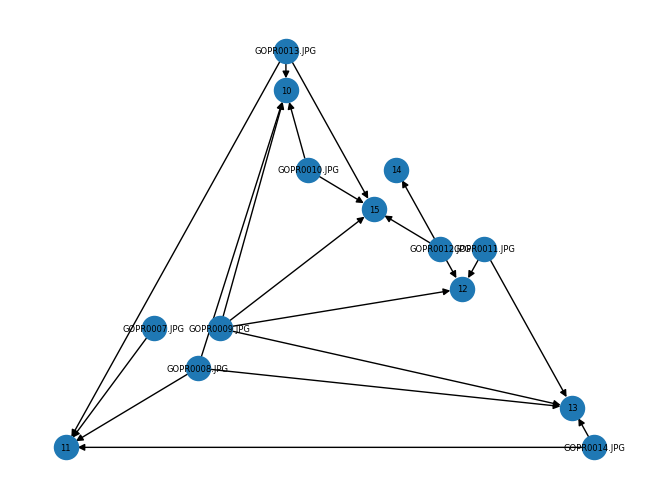

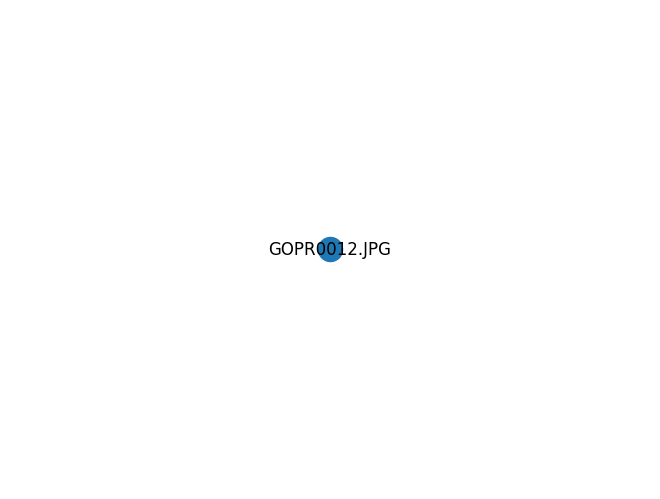

In [43]:
import networkx as nx
import random
import numpy as np
import pathlib
seed = 42
random.seed(seed)
np.random.seed(seed)

# build graph
pose_graph = nx.DiGraph()
for img_path in image_paths:
    rvecs, tvecs, marker_ids, objpts = estimate_april_pose(img_path)
    img_markers = dict()
    node_name = pathlib.Path(img_path).name
    pose_graph.add_node(node_name)
    for rvec, tvec, mid in zip(rvecs, tvecs, marker_ids):
        wpts, trans = convert_to_cam_system(rvec, tvec, marker_world_corners=objpts.reshape((-1,3)))
        # note that these trans tranforms are pose matrices
        img_markers[mid] = (wpts, trans)
        if not pose_graph.has_node(mid):
            pose_graph.add_node(mid)
        
        pose_graph.add_edge(node_name, mid, trans=trans, points3d=wpts.T)

# select largest connected component
components = sorted(nx.connected_components(nx.Graph(pose_graph)), key=len, reverse=True)
pose_graph = pose_graph.subgraph(components[0])
print(f"graph consists of {len(components)} connected component(s), choosing largest")
graph_poses = nx.planar_layout(pose_graph,scale=2.5)
plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses, font_size=6)
plt.show(
)

original_pose_graph = pose_graph.copy()
# execute graph collapse

# (uses side effect)
preprocess(pose_graph, model_key=model_key)
pose_graph = recursive_pose_graph_collapse(pose_graph, pivot_node, model_key, trans_key)

# visualize
extrinsic_matrices = []
for node, trans in pose_graph.nodes[pivot_node][model_key].items():
    if str(node).endswith("JPG"):
        color = "blue"
    else:
        color = "orange"
    extrinsic_matrices.append((str(node),color, inverse_transformation(trans)))

wpts = np.zeros((0,3))

plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses)
plt.show(
)

now redetect some 3d corners and demonstrate how to project them into world coordinates

In [44]:
detect_cam_name = "GOPR0009.JPG" # TODO with 14 it is not so good (200 pixels off) but I don't know what the problem could be. 11 works very well. (both with 14 below). center is 13
img_path = [p for p in image_paths if p.endswith(detect_cam_name)][0]
image_color = cv2.imread(img_path)
world_pose = pose_graph.nodes[pivot_node][model_key][detect_cam_name]

# result and especially objpts are in the coordinate system of the april marker meaning differnt april markers that are detected are not in a common reference frame yet
# alternatively rvec and tvec transformation matrix can be seen as pose of obj points
rvecs, tvecs, mids, objpts = estimate_april_pose(img_path) 
print(objpts.shape)

(4, 1, 3)


In [45]:
rvec = rvecs[0,0,:]
tvec = tvecs[0,0,:].flatten()
objpts = objpts.reshape((-1,3))
objpts

array([[-0.125,  0.125,  0.   ],
       [ 0.125,  0.125,  0.   ],
       [ 0.125, -0.125,  0.   ],
       [-0.125, -0.125,  0.   ]], dtype=float32)

first normal reprojection

In [46]:
E  = np.eye(4)
E[:3,:3] = cv2.Rodrigues(rvec)[0]
E[:3,3] = tvec.flatten()
E

array([[-0.96698743,  0.1918617 ,  0.1677033 , -1.07583705],
       [-0.17685524, -0.03148895, -0.98373303,  1.77247142],
       [-0.18345989, -0.98091668,  0.06438117,  2.79804691],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [47]:
def observe_3d_pts(E,K, wpts):
    """E ist the  *camera extrinsic matrix*"""
    camera_mat = np.eye(4)
    camera_mat[:3,:3] = K
    camera_extrinsics = E
    P = camera_mat @ camera_extrinsics
    P = P[:3,:] # we only had 4 rows for multiplication before
    world_corners = wpts
    image_pts = P @ np.hstack((world_corners,np.ones((world_corners.shape[0],1)))).T
    # recover homogeneous coordinates
    image_pts = image_pts / image_pts[-1,:]
    image_pts = image_pts[:2,:]
    return image_pts
image_pts = observe_3d_pts(E, mtx, objpts) #marker  camera coords
image_pts

array([[1795.28132431, 1573.28751984, 1620.98317218, 1823.73963736],
       [3709.42300926, 3697.22995881, 3572.8091929 , 3585.9250823 ]])

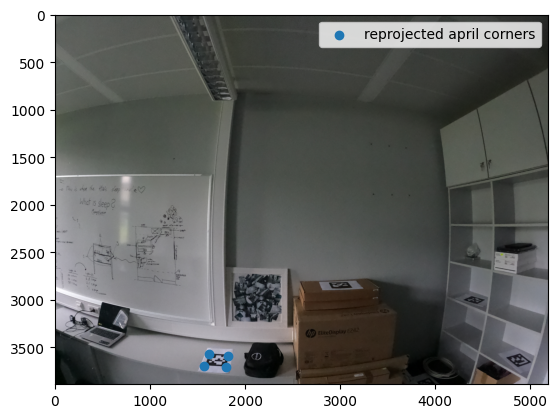

In [48]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected april corners")
plt.legend()

In [49]:
objpts_hom = np.hstack((objpts,np.ones((4,1)))).T
objpts_cam = E @ objpts_hom
objpts_cam = objpts_cam / objpts_cam[-1,:]
objpts_cam = objpts_cam[:3,:]
objpts_cam = objpts_cam.T
objpts_cam

array([[-0.93098091,  1.7906422 ,  2.69836481],
       [-1.17272777,  1.74642839,  2.65249984],
       [-1.22069319,  1.75430063,  2.89772901],
       [-0.97894633,  1.79851444,  2.94359399]])

In [50]:
image_pts = observe_3d_pts(np.eye(4), mtx, objpts_cam) # camera coords
image_pts

array([[1795.28132431, 1573.28751984, 1620.98317218, 1823.73963736],
       [3709.42300926, 3697.22995881, 3572.8091929 , 3585.9250823 ]])

now convert to calibrated world frame

In [51]:
objpts_cam_hom = np.hstack((objpts_cam,np.ones((4,1)))).T
objpts_world = world_pose @ objpts_cam_hom
objpts_world = objpts_world / objpts_world[-1,:]
objpts_world = objpts_world[:3,:]
objpts_world = objpts_world.T
objpts_world

array([[-2.69689251,  1.30125556, -0.35701747],
       [-2.90411167,  1.29699468, -0.49681039],
       [-2.96022093,  1.07063476, -0.40673856],
       [-2.75300177,  1.07489563, -0.26694563]])

observe with same camera but from world pose

array([[1795.28132431, 1573.28751984, 1620.98317218, 1823.73963736],
       [3709.42300926, 3697.22995881, 3572.8091929 , 3585.9250823 ]])

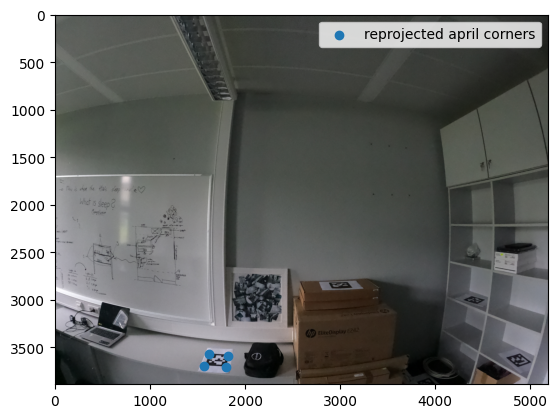

In [52]:
image_pts = observe_3d_pts(np.linalg.inv(world_pose), mtx, objpts_world) #marker  camera coords
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected april corners")
plt.legend()
image_pts

observe points with other camera

array([[-451.52541828, -921.2130373 , -554.44638252, -157.03206775],
       [1419.87103203, 1321.44899589, 1450.5564669 , 1531.94943599]])

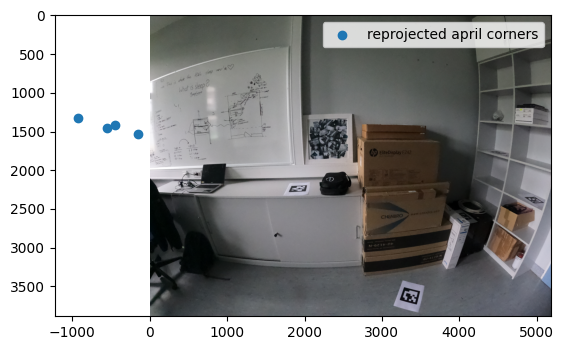

In [53]:
other_cam_name = "GOPR0008.JPG" # I originally had 14 here
world_pose = pose_graph.nodes[pivot_node][model_key][other_cam_name]
img_path = [p for p in image_paths if p.endswith(other_cam_name)][0]
image_color = cv2.imread(img_path)
image_pts = observe_3d_pts(np.linalg.inv(world_pose), mtx, objpts_world) #marker  camera coords
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected april corners")
plt.legend()
image_pts

compute consistency error for node

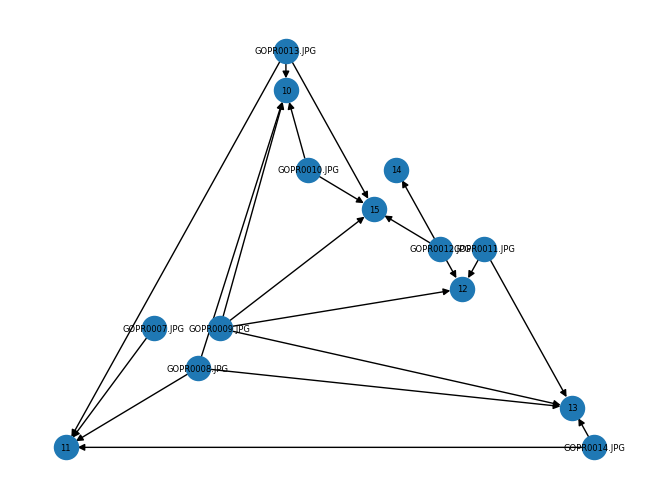

In [54]:
plt.figure()
nx.draw(original_pose_graph, with_labels=True, pos=graph_poses, font_size=6)
plt.show(
)

In [55]:
# proof that formula works:
P1 = pose_graph.nodes[pivot_node][model_key]["GOPR0008.JPG"]
P2 = pose_graph.nodes[pivot_node][model_key]["GOPR0014.JPG"]
T_rel1 = P1 @ np.linalg.inv(P2)
T_rel2 = P1 @ np.linalg.inv(P2)
T_diff = T_rel1 @ np.linalg.inv(T_rel2)
print(T_diff)
diff = np.linalg.norm(T_diff, ord="fro")
print(diff)
np.linalg.norm(np.eye(4),ord="fro")

[[ 1.00000000e+00  1.25197589e-17  1.53097996e-17  0.00000000e+00]
 [-1.24134858e-17  1.00000000e+00 -3.50200763e-17 -8.88178420e-16]
 [-5.15858150e-17  1.00997271e-17  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
2.0


np.float64(2.0)

In [56]:
def consistency_error(original_graph: nx.DiGraph, transforms: dict, node):
    out_neighbors = [ (n[1], original_graph.edges[*n][trans_key]) for n in original_graph.out_edges(node)] 
    in_neighbors = [ (n[0], original_graph.edges[*n][trans_key]) for n in original_graph.in_edges(node)] 
    in_neighbors = [(n, inverse_transformation(t)) for (n,t) in in_neighbors] # this lets us handle every edge if it was outgoing
    neighbors = out_neighbors + in_neighbors # every transformation now is a pose matrix (as opposed to extrinsic)
    differences = []
    for n, pose in neighbors:
        #print("node"+str(n)+"\n")
        #print(transforms[node],transforms[n],"\n")
        E_rel = transforms[node] @ np.linalg.inv(transforms[n])
        T_rel = np.linalg.inv(E_rel)
        T_diff = T_rel @ np.linalg.inv(pose)
        diff = np.linalg.norm(T_diff, ord="fro") # minimum is 2
        differences.append(diff**2) # square to prefer |--.--| over |-.---|

    return np.array(differences)


# build artificial example with initial (thus perfect) transforms
inspect_node = "GOPR0008.JPG"
out_neighbors = [ (n[1], original_pose_graph.edges[*n][trans_key]) for n in original_pose_graph.out_edges(inspect_node)] 
in_neighbors = [ (n[0], original_pose_graph.edges[*n][trans_key]) for n in original_pose_graph.in_edges(inspect_node)] 
in_neighbors = [(n, inverse_transformation(t)) for (n,t) in in_neighbors] # this lets us handle every edge if it was outgoing
neighbors = out_neighbors + in_neighbors # every transformation now is a pose matrix (as opposed to extrinsic)
transforms = dict()
for n, pose in neighbors:
    transforms[n] = pose
transforms[inspect_node] = np.eye(4)
squared_norms = consistency_error(original_pose_graph, transforms, inspect_node)
squared_norms


array([4., 4., 4.])

In [57]:

# actually try on some node

inspect_node = "GOPR0012.JPG" # this is actually perfect because it is pivot node
inspect_node = "GOPR0011.JPG"
squared_norms = consistency_error(original_pose_graph, pose_graph.nodes[pivot_node][model_key], inspect_node)
np.sum(squared_norms) , [np.sqrt(v) for v in  squared_norms]

(np.float64(17.466170654421447),
 [np.float64(2.8078999054174827), np.float64(3.095459380379258)])

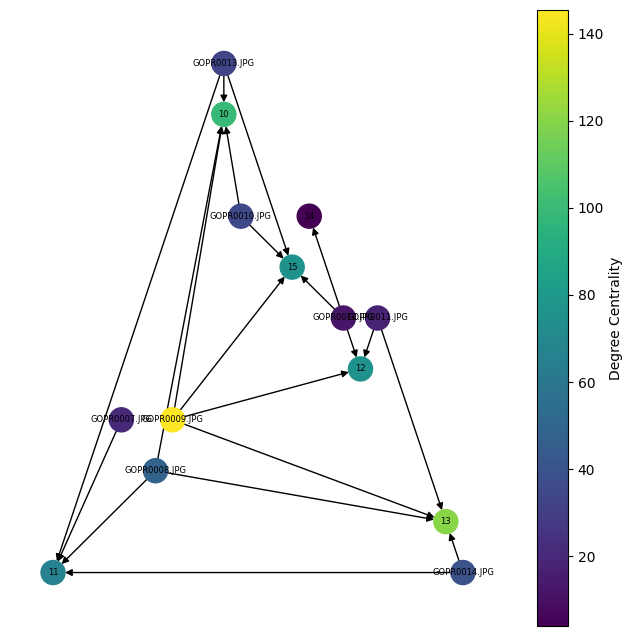

In [58]:
def consistency_centrality(pose_graph: nx.DiGraph, poses: dict, node):
    errors = consistency_error(pose_graph, poses, node)
    neighbors = pose_graph.in_degree(node) + pose_graph.out_degree(node)
    #errors = errors / neighbors
    centrality = np.sum(errors)
    return centrality

def draw_consistency_colors(pose_graph: nx.DiGraph, poses: dict, pos=None):
    node_colors = []
    for node in pose_graph.nodes():
        err = consistency_centrality(pose_graph, poses, node)
        node_colors.append(np.sum(err).item())

    draw_with_colors(pose_graph, node_colors, pos=pos)

def draw_with_colors(G, node_centralities, pos=None):
    # Normalize the color values to the range [0, 1]
    #node_colors = (np.array(node_centralities) - min(node_centralities)) / (max(node_centralities) - min(node_centralities))
    node_colors = node_centralities

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Draw the graph with the node color map
    nx.draw(G, with_labels=True, pos=pos, font_size=6,node_color=node_colors)
    #nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), node_color=node_colors, cmap='viridis', ax=ax)
    #nx.draw_networkx_edges(G, pos=nx.spring_layout(G), ax=ax)
    #nx.draw_networkx_labels(G, pos=nx.spring_layout(G), ax=ax)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Degree Centrality')

    plt.show()

draw_consistency_colors(original_pose_graph, pose_graph.nodes[pivot_node][model_key], pos=graph_poses)

Build hill climber

In [59]:
def fit_model(pose_graph: nx.DiGraph, modifications: dict,pivot_node, model_key=model_key, trans_key=trans_key):
    """modification contains a rigid transformation for each node indexed by its key"""
    original_pose_graph = pose_graph.copy()
    preprocess(pose_graph, model_key=model_key)
    pose_graph = recursive_pose_graph_collapse(pose_graph, pivot_node, model_key, trans_key)
    # apply modifications
    for _n in original_pose_graph.nodes():
        pose_graph.nodes[pivot_node][model_key][_n] = modifications[_n] @ pose_graph.nodes[pivot_node][model_key][_n]
    all_errs = 0.0
    for n in original_pose_graph.nodes():
        squared_norms = consistency_error(original_pose_graph, pose_graph.nodes[pivot_node][model_key], n)
        all_errs += np.sum(squared_norms)
    return pose_graph, all_errs

res, err = fit_model(original_pose_graph.copy(), {n: np.eye(4) for n in original_pose_graph.nodes()},pivot_node)
res, err

(<networkx.classes.digraph.DiGraph at 0x7f193387e780>,
 np.float64(792.9743600779146))

In [60]:
from copy import deepcopy
def decompose_transform(transform_matrix):
    """
    Decomposes a 4x4 transformation matrix into roll, pitch, yaw angles (in degrees) and the translation vector.
    
    Args:
        transform_matrix (numpy.ndarray): A 4x4 transformation matrix.
    
    Returns:
        tuple: A tuple containing the roll, pitch, yaw angles (in degrees) and the translation vector.
    """
      # Extract the rotation matrix from the transformation matrix
    rotation_matrix = transform_matrix[:3, :3]
    
    # Convert the rotation matrix to a rotation vector
    rotation_vector, _ = cv2.Rodrigues(rotation_matrix)
    
    # Extract the roll, pitch, and yaw angles from the rotation vector
    roll = rotation_vector[0, 0]
    pitch = rotation_vector[1, 0]
    yaw = rotation_vector[2, 0]
    
    # Convert the angles from radians to degrees
    roll_deg = np.rad2deg(roll)
    pitch_deg = np.rad2deg(pitch)
    yaw_deg = np.rad2deg(yaw)
    
    # Extract the translation vector
    translation = transform_matrix[:3, 3]
    
    return (roll_deg, pitch_deg, yaw_deg, translation)

def add_to_angle(angle, increment):
    """ makes sure everything is in [-1,1] for valid quaternions"""
    res =  (angle + increment) 
    if res < -1:
        res += 2
    if res > 1:
        res -= 2

    return res

def quaternion_to_rotation_matrix(q):
    q_w, q_x, q_y, q_z = q
    theta = 2 * np.arccos(q_w)
    n_x = q_x / np.sin(theta/2)
    n_y = q_y / np.sin(theta/2)
    n_z = q_z / np.sin(theta/2)
    rotation_vector = theta * np.array([n_x, n_y, n_z])
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    return rotation_matrix

class Genome:
    def __init__(self,rotations: dict, translations: dict, pivot: int, num_nodes: int):
        self.rotations = rotations
        self.translations = translations
        self.pivot = pivot
        self.num_nodes = num_nodes


    def mutate(self) -> 'Genome':
        new_rotations = dict()
        random_index = random.randint(0, len(self.rotations.items()) - 1)

        for i, tup in enumerate(self.rotations.items()):
            node, rotation = tup

            if i == random_index and random.randint(0,4)>=1: 
                samples = np.random.normal(loc=0, scale=0.01, size=4)
                new_rotations[node] = (add_to_angle(rotation[0] ,samples[0]),add_to_angle(rotation[1] , samples[1]),add_to_angle(rotation[2],samples[2]),add_to_angle(rotation[3],samples[3]))
            else:
                new_rotations[node] = deepcopy(rotation)

        new_translations = dict()
        for i, tup in enumerate(self.translations.items()):
            node, translation = tup
            if i == random_index and random.randint(0,4)>=1: 
                samples = np.random.normal(loc=0, scale=1.0, size=3)
                new_translations[node] = (translation[0]+samples[0],translation[1]+samples[1],translation[2]+samples[2])
            else:
                new_translations[node] = deepcopy(translation)

        #new_translations = self.translations

        sample = np.random.choice([-1, 0, 1], size=1, p=[0.25, 0.5, 0.25])[0]
        new_pivot = (self.pivot + sample) % self.num_nodes
        if random.randint(0,2)>1: 
            new_pivot = random.randint(0, self.num_nodes-1)

        return Genome(new_rotations, new_translations, new_pivot, self.num_nodes)


    def get_transforms(self) -> dict:
        transforms = dict()
        for node in self.rotations.keys():
            rot = self.rotations[node]
            rotmat = quaternion_to_rotation_matrix(rot)
            trans = self.translations[node]
            T = np.eye(4)
            tvec = np.array(trans)
            T[:3,:3] = rotmat
            T[:3,3] = tvec.flatten()
            transforms[node] = T

        return transforms

genome = Genome({n:(0,0,0,0) for n in original_pose_graph.nodes()}, {n:(0,0,0) for n in original_pose_graph.nodes()}, 0, len(original_pose_graph.nodes()))
decompose_transform(list(genome.mutate().get_transforms().values())[0])

(np.float64(0.0), np.float64(0.0), np.float64(0.0), array([0., 0., 0.]))

In [61]:
from copy import deepcopy
def hill_climber(pose_graph: nx.DiGraph, best_n=5,population_size=10,inertia=10,initial_pivot = 0,model_key=model_key, trans_key=trans_key):
    nodes = sorted(list(pose_graph.nodes()), key=lambda item: str(item))
    population = [Genome({n:(0,0,0,0) for n in nodes}, {n:(0,0,0) for n in nodes}, initial_pivot, len(nodes))] * population_size
    
    best_fitness = np.inf
    best_genomes = population[:best_n]
    ct = 0
    inertia_counter = 0
    while True:

        fitnesses = dict()
        for i, genome in enumerate(population):
            modifications = genome.get_transforms()
            pivot = nodes[genome.pivot]
            _res, fitness = fit_model(pose_graph.copy(), modifications, pivot, model_key=model_key, trans_key=trans_key)
            fitnesses[i] = fitness
        fitnesses = dict(sorted(fitnesses.items(), key=lambda item: item[1])) # sort dict keys (=genome indices) by fitness
        best_genome_index, fitness = list(fitnesses.items())[0]

        # we want to mimimize fitness actually
        if fitness < best_fitness:
            inertia_counter = 0
            best_fitness = fitness
            best_genome = population[best_genome_index]
        best_genomes = list(fitnesses.items())[:best_n]
        best_genomes = deepcopy([population[bg[0]] for bg in best_genomes])
        population = [g.mutate() for g in population] # mutate all of population
        population[:best_n] = best_genomes # but keep best ones, killing some random
        population[best_n:] = [g.mutate() for g in best_genomes] # also keep mutations of best ones killing some random more
        # this should ensure a large exploration space while optimizing
        
        print(f"{ct=}, {best_fitness=}, {fitness=}, {inertia_counter=}|", flush=True,end="\r" )
        if fitness >= best_fitness and inertia_counter > inertia:
            break
        elif fitness >= best_fitness:
            inertia_counter += 1
        
        ct += 1

    modifications = best_genome.get_transforms()
    pivot = nodes[best_genome.pivot]
    res, fitness = fit_model(pose_graph.copy(), modifications, pivot, model_key=model_key, trans_key=trans_key)
    return res, fitness, pivot, modifications
    
seed = 42
random.seed(seed)
np.random.seed(seed)
res, fitness, pivot, modifications = hill_climber(original_pose_graph.copy(), best_n=5,population_size=50,inertia=50,initial_pivot = 0,model_key=model_key, trans_key=trans_key)

In [62]:
print(f"pivot node: {pivot}")
print(f"fitness: {fitness}")
{n:([t.item() for t in decompose_transform(t)[:3]],decompose_transform(t)[3]) for n,t in modifications.items()}

pivot node: GOPR0012.JPG
fitness: 429.9871457765069


{10: ([-4.153834937411139, 1.20548992341672, -2.8958262531752665],
  array([ 1.1130974 ,  0.04699039, -0.02772313])),
 11: ([-0.04801308646890683, 6.660440979077155, 6.299808586926387],
  array([ 0.13478085, -0.57944534,  0.56049956])),
 12: ([0.4278406715923624, 2.7892615611401106, 6.53710851288986],
  array([0.02043964, 0.20277295, 0.66449375])),
 13: ([-2.948150711248399, -2.601805820473102, 1.2478365513791545],
  array([-0.38720857, -0.1946279 ,  0.8986093 ])),
 14: ([-5.430856729588206, -3.858709046162119, 4.226742150947818],
  array([ 0.12763493, -0.01101374,  0.54528441])),
 15: ([-3.942436127183799, 3.1073890532782653, -1.3861977434772268],
  array([0.37060279, 0.90927384, 2.1181894 ])),
 'GOPR0007.JPG': ([3.6629250795999924, 5.3796824745572644, 0.6737025207812725],
  array([-1.5909167 , -1.90494481,  0.22321318])),
 'GOPR0008.JPG': ([5.272192450969943, 5.039363837024815, 8.145415081075393],
  array([ 2.4269935 , -0.28466753,  0.77182807])),
 'GOPR0009.JPG': ([0.615531510603767

evaluate optimized model

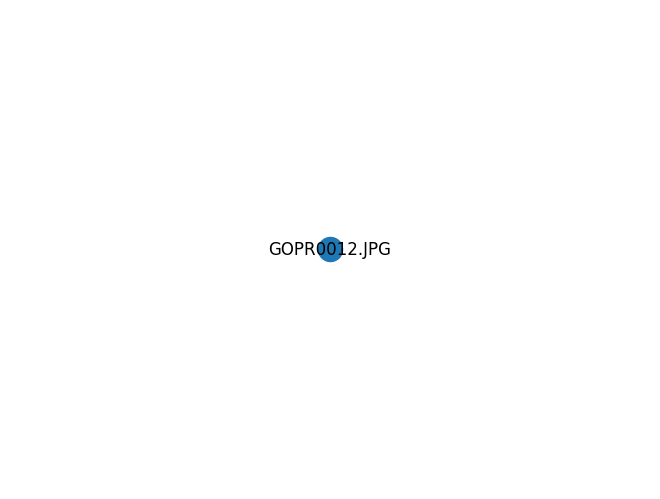

In [63]:
pose_graph = res
plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses)
plt.show(
)

(4, 1, 3)
[[-0.96698743  0.1918617   0.1677033  -1.07583705]
 [-0.17685524 -0.03148895 -0.98373303  1.77247142]
 [-0.18345989 -0.98091668  0.06438117  2.79804691]
 [ 0.          0.          0.          1.        ]] [[2.28612089e+03 0.00000000e+00 2.58403120e+03]
 [0.00000000e+00 2.34742270e+03 2.15166695e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] (4, 3)


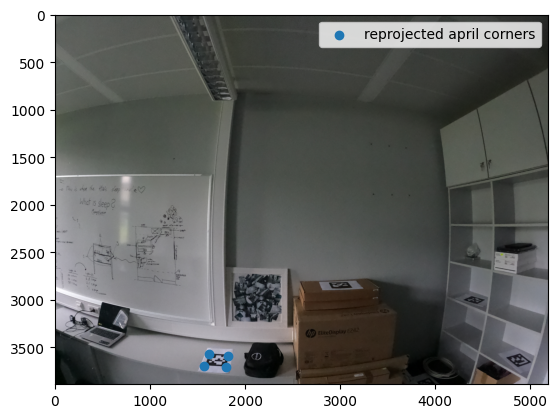

In [64]:
pivot_node = list(pose_graph.nodes())[0]
img_path = [p for p in image_paths if p.endswith(detect_cam_name)][0]
image_color = cv2.imread(img_path)
world_pose = pose_graph.nodes[pivot_node][model_key][detect_cam_name]
rvecs, tvecs, mids, objpts = estimate_april_pose(img_path) 
print(objpts.shape)

rvec = rvecs[0,0,:]
tvec = tvecs[0,0,:].flatten()
objpts = objpts.reshape((-1,3))
objpts

E  = np.eye(4)
E[:3,:3] = cv2.Rodrigues(rvec)[0]
E[:3,3] = tvec.flatten()
E
print(E, mtx, objpts.shape)
image_pts = observe_3d_pts(E, mtx, objpts) #marker  camera coords
image_pts

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected april corners")
plt.legend()

observe with same camera but from world pose

array([[1795.28132431, 1573.28751984, 1620.98317218, 1823.73963736],
       [3709.42300926, 3697.22995881, 3572.8091929 , 3585.9250823 ]])

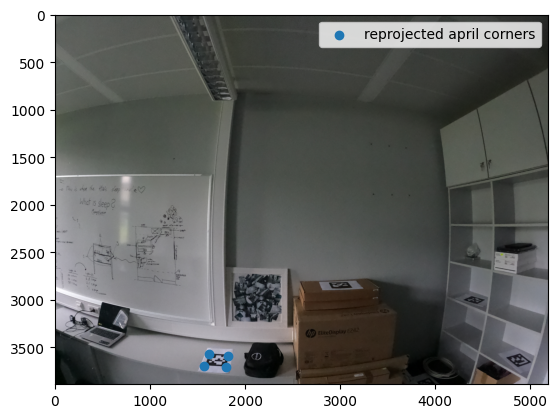

In [65]:
objpts_hom = np.hstack((objpts,np.ones((4,1)))).T
objpts_cam = E @ objpts_hom
objpts_cam = objpts_cam / objpts_cam[-1,:]
objpts_cam = objpts_cam[:3,:]
objpts_cam = objpts_cam.T
objpts_cam
image_pts = observe_3d_pts(np.eye(4), mtx, objpts_cam) # camera coords
image_pts
objpts_cam_hom = np.hstack((objpts_cam,np.ones((4,1)))).T
objpts_world = world_pose @ objpts_cam_hom
objpts_world = objpts_world / objpts_world[-1,:]
objpts_world = objpts_world[:3,:]
objpts_world = objpts_world.T
objpts_world
image_pts = observe_3d_pts(np.linalg.inv(world_pose), mtx, objpts_world) #marker  camera coords
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected april corners")
plt.legend()
image_pts

observe points with other camera

array([[ 669.97536113,  366.10768384,  476.89492423,  749.090612  ],
       [3876.75916534, 3835.69843189, 3713.10962483, 3754.53528952]])

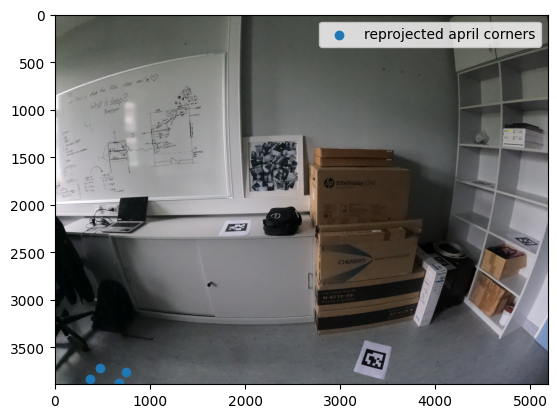

In [66]:
world_pose = pose_graph.nodes[pivot_node][model_key][other_cam_name]
img_path = [p for p in image_paths if p.endswith(other_cam_name)][0]
image_color = cv2.imread(img_path)
image_pts = observe_3d_pts(np.linalg.inv(world_pose), mtx, objpts_world) #marker  camera coords
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected april corners")
plt.legend()
image_pts

somehow the optimal consistency does not correspond to better global model

show consistency error centrality

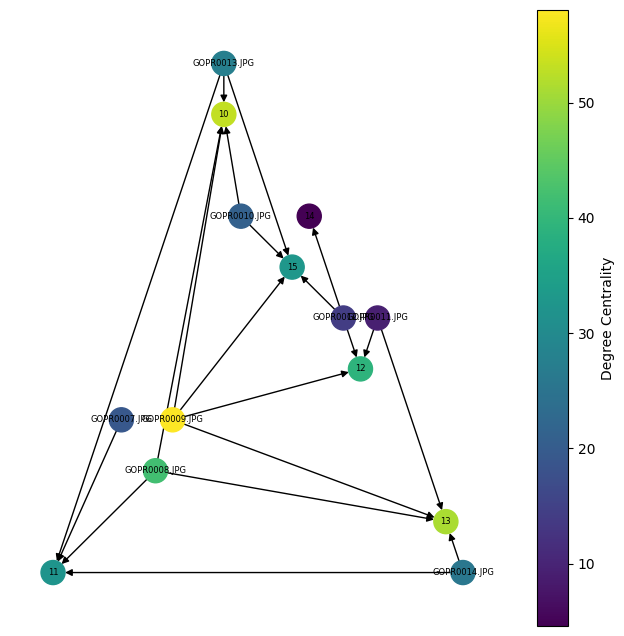

In [67]:
draw_consistency_colors(original_pose_graph, pose_graph.nodes[pivot_node][model_key], pos=graph_poses)

now try with disabeling edges as genome

In [68]:
def fit_model_edges(pose_graph: nx.DiGraph, edges: dict,pivot_node, model_key=model_key, trans_key=trans_key):
    """modification contains a rigid transformation for each node indexed by its key"""
    original_pose_graph = pose_graph.copy()
    pose_graph = pose_graph.copy()

    for edge,v in edges.items():
        if v == False:
            pose_graph.remove_edge(edge[0],edge[1])
    components = sorted(nx.connected_components(nx.Graph(pose_graph)), key=len, reverse=True)
    if len(components) > 1:
        return pose_graph, np.inf
    mod_pose_graph = pose_graph.copy()
    preprocess(pose_graph, model_key=model_key)
    pose_graph = recursive_pose_graph_collapse(pose_graph, pivot_node, model_key, trans_key)
    # apply modifications
    #for _n in original_pose_graph.nodes():
    #    pose_graph.nodes[pivot_node][model_key][_n] = modifications[_n] @ pose_graph.nodes[pivot_node][model_key][_n]
    all_errs = 0.0
    for n in original_pose_graph.nodes():
        squared_norms = consistency_centrality(mod_pose_graph, pose_graph.nodes[pivot_node][model_key], n)
        #deg = (mod_pose_graph.in_degree(n) + mod_pose_graph.out_degree(n))
        all_errs += np.sum(squared_norms)#/deg
    return pose_graph, all_errs

edges = list(original_pose_graph.edges())
edges_model = {e: True for e in edges}
#edges_model[edges[5]] = False
#edges_model[edges[6]] = False

res, err = fit_model_edges(original_pose_graph.copy(), edges_model,pivot_node)
res, err

(<networkx.classes.digraph.DiGraph at 0x7f18d9144cb0>,
 np.float64(792.9743600779146))

In [69]:
class Genome_edges:
    def __init__(self,edges_model: dict, pivot: int, num_nodes: int):
        self.edges_model = edges_model
        self.pivot = pivot
        self.num_nodes = num_nodes


    def mutate(self) -> 'Genome_edges':
        new_model = dict()
        randindex = random.randint(0, len(self.edges_model.items()) - 1)

        for i, tup in enumerate(self.edges_model.items()):
            edge, val = tup
            if i == randindex:
                new_model[edge] = not val
            else:
                new_model[edge] = val

        #new_translations = self.translations

        sample = np.random.choice([-1, 0, 1], size=1, p=[0.25, 0.5, 0.25])[0]
        new_pivot = (self.pivot + sample) % self.num_nodes
        if random.randint(0,2)>1: 
            new_pivot = random.randint(0, self.num_nodes-1)

        return Genome_edges(new_model, new_pivot, self.num_nodes)

In [70]:
def hill_climber_edges(pose_graph: nx.DiGraph, best_n=5,population_size=10,inertia=10,initial_pivot = 0,model_key=model_key, trans_key=trans_key):
    nodes = sorted(list(pose_graph.nodes()), key=lambda item: str(item))
    population = [Genome_edges({e:True for n in nodes for e in pose_graph.edges()}, initial_pivot, len(nodes))] * population_size
    
    best_fitness = np.inf
    best_genomes = population[:best_n]
    ct = 0
    inertia_counter = 0
    while True:

        fitnesses = dict()
        for i, genome in enumerate(population):
            modifications = genome.edges_model
            pivot = nodes[genome.pivot]
            _res, fitness = fit_model_edges(pose_graph.copy(), modifications, pivot, model_key=model_key, trans_key=trans_key)
            fitnesses[i] = fitness
        fitnesses = dict(sorted(fitnesses.items(), key=lambda item: item[1])) # sort dict keys (=genome indices) by fitness
        best_genome_index, fitness = list(fitnesses.items())[0]

        # we want to mimimize fitness actually
        if fitness < best_fitness:
            inertia_counter = 0
            best_fitness = fitness
            best_genome = population[best_genome_index]
        best_genomes = list(fitnesses.items())[:best_n]
        best_genomes = deepcopy([population[bg[0]] for bg in best_genomes])
        population = [g.mutate() for g in population] # mutate all of population
        population[:best_n] = best_genomes # but keep best ones, killing some random
        population[best_n:] = [g.mutate() for g in best_genomes] # also keep mutations of best ones killing some random more
        # this should ensure a large exploration space while optimizing
        
        print(f"{ct=}, {best_fitness=}, {fitness=}, {inertia_counter=}|", flush=True,end="\r" )
        if fitness >= best_fitness and inertia_counter > inertia:
            break
        elif fitness >= best_fitness:
            inertia_counter += 1
        
        ct += 1

    modifications = best_genome.edges_model
    pivot = nodes[best_genome.pivot]
    res, fitness = fit_model_edges(pose_graph.copy(), modifications, pivot, model_key=model_key, trans_key=trans_key)
    return res, fitness, pivot, modifications
    
seed = 42
random.seed(seed)
np.random.seed(seed)
res, fitness, pivot, modifications = hill_climber_edges(original_pose_graph.copy(), best_n=5,population_size=50,inertia=100,initial_pivot = 0,model_key=model_key, trans_key=trans_key)

In [71]:
pose_graph.nodes()

NodeView(('GOPR0012.JPG',))

{('GOPR0007.JPG', 11): True, ('GOPR0008.JPG', 11): True, ('GOPR0008.JPG', 10): False, ('GOPR0008.JPG', 13): False, ('GOPR0009.JPG', 10): False, ('GOPR0009.JPG', 13): True, ('GOPR0009.JPG', 15): True, ('GOPR0009.JPG', 12): False, ('GOPR0010.JPG', 15): True, ('GOPR0010.JPG', 10): False, ('GOPR0011.JPG', 12): True, ('GOPR0011.JPG', 13): False, ('GOPR0012.JPG', 15): True, ('GOPR0012.JPG', 12): True, ('GOPR0012.JPG', 14): True, ('GOPR0013.JPG', 15): True, ('GOPR0013.JPG', 10): True, ('GOPR0013.JPG', 11): True, ('GOPR0014.JPG', 13): False, ('GOPR0014.JPG', 11): True}


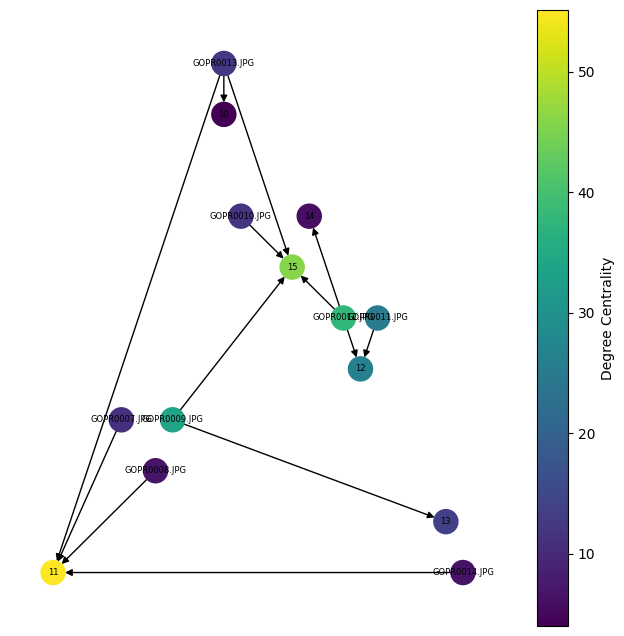

In [72]:
pose_graph = res
pivot_node = pivot
mod_pose_graph = original_pose_graph.copy()
print(modifications)
for edge,v in modifications.items():
    if v == False:
        mod_pose_graph.remove_edge(edge[0],edge[1])
draw_consistency_colors(mod_pose_graph, pose_graph.nodes[pivot_node][model_key], pos=graph_poses)

(4, 1, 3)
[[-0.96698743  0.1918617   0.1677033  -1.07583705]
 [-0.17685524 -0.03148895 -0.98373303  1.77247142]
 [-0.18345989 -0.98091668  0.06438117  2.79804691]
 [ 0.          0.          0.          1.        ]] [[2.28612089e+03 0.00000000e+00 2.58403120e+03]
 [0.00000000e+00 2.34742270e+03 2.15166695e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] (4, 3)


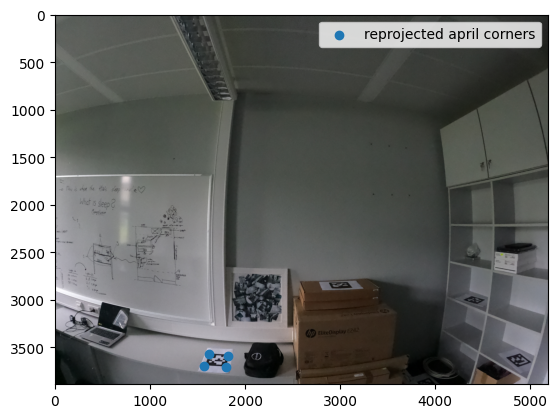

In [73]:
pivot_node = list(pose_graph.nodes())[0]
img_path = [p for p in image_paths if p.endswith(detect_cam_name)][0]
image_color = cv2.imread(img_path)
world_pose = pose_graph.nodes[pivot_node][model_key][detect_cam_name]
rvecs, tvecs, mids, objpts = estimate_april_pose(img_path) 
print(objpts.shape)

rvec = rvecs[0,0,:]
tvec = tvecs[0,0,:].flatten()
objpts = objpts.reshape((-1,3))
objpts

E  = np.eye(4)
E[:3,:3] = cv2.Rodrigues(rvec)[0]
E[:3,3] = tvec.flatten()
E
print(E, mtx, objpts.shape)
image_pts = observe_3d_pts(E, mtx, objpts) #marker  camera coords
image_pts

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected april corners")
plt.legend()

observe with same camera but from world pose

array([[1795.28132431, 1573.28751984, 1620.98317218, 1823.73963736],
       [3709.42300926, 3697.22995881, 3572.8091929 , 3585.9250823 ]])

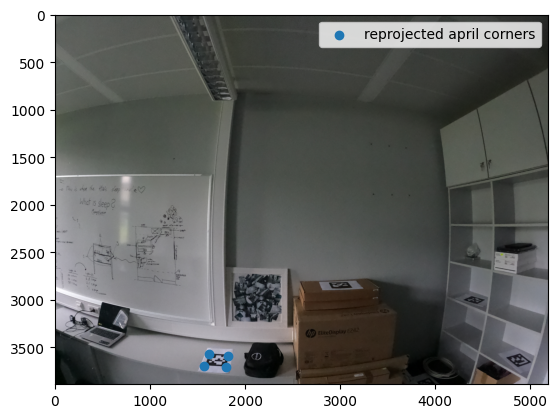

In [74]:
objpts_hom = np.hstack((objpts,np.ones((4,1)))).T
objpts_cam = E @ objpts_hom
objpts_cam = objpts_cam / objpts_cam[-1,:]
objpts_cam = objpts_cam[:3,:]
objpts_cam = objpts_cam.T
objpts_cam
image_pts = observe_3d_pts(np.eye(4), mtx, objpts_cam) # camera coords
image_pts
objpts_cam_hom = np.hstack((objpts_cam,np.ones((4,1)))).T
objpts_world = world_pose @ objpts_cam_hom
objpts_world = objpts_world / objpts_world[-1,:]
objpts_world = objpts_world[:3,:]
objpts_world = objpts_world.T
objpts_world
image_pts = observe_3d_pts(np.linalg.inv(world_pose), mtx, objpts_world) #marker  camera coords
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected april corners")
plt.legend()
image_pts

observe points with other camera

In [75]:
detect_cam_name,other_cam_name

('GOPR0009.JPG', 'GOPR0008.JPG')

array([[1948.2057229 , 1804.81762789, 1849.79259302, 1984.33164699],
       [2963.46739659, 3021.5478365 , 2997.02147834, 2942.55756078]])

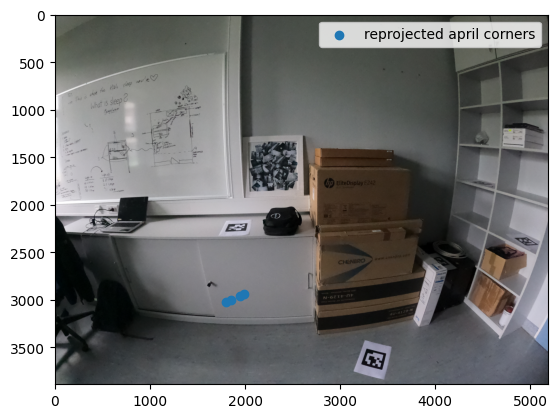

In [76]:
world_pose = pose_graph.nodes[pivot_node][model_key][other_cam_name]
img_path = [p for p in image_paths if p.endswith(other_cam_name)][0]
image_color = cv2.imread(img_path)
image_pts = observe_3d_pts(np.linalg.inv(world_pose), mtx, objpts_world) #marker  camera coords
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected april corners")
plt.legend()
image_pts

compute edge consistency error (in contrast to node) and reject edges above threshold

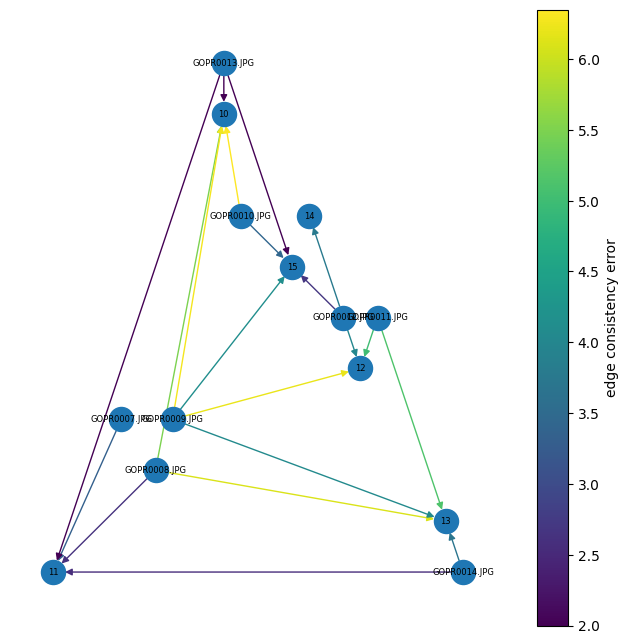

In [92]:
def edge_consistency(original_graph: nx.DiGraph, transforms: dict, edge):
    edge_trans = original_graph.get_edge_data(*edge)[trans_key]
    world_trans = transforms[edge[1]] @ np.linalg.inv(transforms[edge[0]])
    diff = edge_trans @ np.linalg.inv(world_trans)
    diff = np.linalg.norm(diff, ord="fro") # minimum is 2
    return diff

def draw_with_edge_colors(G, node_centralities, edge_centralities, pos=None):
    # Normalize the color values to the range [0, 1]
    #node_colors = (np.array(node_centralities) - min(node_centralities)) / (max(node_centralities) - min(node_centralities))
    node_colors = node_centralities
    edge_colors = edge_centralities

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Draw the graph with the node color map
    nx.draw(G, with_labels=True, pos=pos, font_size=6,node_color=node_colors, edge_color=edge_colors)
    #nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), node_color=node_colors, cmap='viridis', ax=ax)
    #nx.draw_networkx_edges(G, pos=nx.spring_layout(G), ax=ax)
    #nx.draw_networkx_labels(G, pos=nx.spring_layout(G), ax=ax)

    # Add a colorbar
    if node_colors:
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('edge consistency error')

    if edge_colors:
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('edge consistency error')

    plt.show()

def draw_edge_consistency(pose_graph: nx.DiGraph, poses: dict, pos=None):
    edge_colors = []
    for edge in pose_graph.edges():
        err = edge_consistency(pose_graph, poses, edge)
        edge_colors.append(err)

    draw_with_edge_colors(pose_graph, None, edge_colors, pos=pos)

draw_edge_consistency(original_pose_graph, pose_graph.nodes[pivot_node][model_key], pos=graph_poses)